In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
# import libraries
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pprint import pprint
import xgboost
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from xgboost import XGBClassifier
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. Functions and get data

In [102]:
# print cross validation metrics
def get_cv_roc_pr_rc(clf, skf, X, y):
    roc_auc = []
    pr_auc = []
    precision = []
    recall = []
    models = []
    for train, test in skf.split(X, y):
        models.append(clf.fit(X.iloc[train,:], y.iloc[train]))
        y_pred = clf.predict(X.iloc[test,:])
        y_pred_prob = clf.predict_proba(X.iloc[test,:])[:,1]
        roc_auc.append(roc_auc_score(y.iloc[test], y_pred_prob))
        pr_auc.append(average_precision_score(y.iloc[test], y_pred_prob))
        precision.append(precision_score(y.iloc[test], y_pred))
        recall.append(recall_score(y.iloc[test], y_pred))

    print ('ROC-AUC:', np.mean(roc_auc))
    print ('PR-AUC:', np.mean(pr_auc))
    print ('Precission:', np.mean(precision))
    print ('Recall:', np.mean(recall))
    
    return roc_auc, pr_auc, precision, recall, models

In [103]:
# print cross validation metrics two
def get_cv_roc_pr_rc_2(clf, skf, X, y):
    roc_auc = []
    pr_auc = []
    precision = []
    recall = []
    models = []
    for train, test in skf.split(X, y):
        models.append(clf.fit(X.iloc[train,:], y.iloc[train]))
        y_pred = clf.predict(X.iloc[test,:])
        #y_pred_prob = clf.predict_proba(X.iloc[test,:])[:,1]
        roc_auc.append(roc_auc_score(y.iloc[test], y_pred))
        pr_auc.append(average_precision_score(y.iloc[test], y_pred))
        precision.append(precision_score(y.iloc[test], y_pred))
        recall.append(recall_score(y.iloc[test], y_pred))

    print ('ROC-AUC:', np.mean(roc_auc))
    print ('PR-AUC:', np.mean(pr_auc))
    print ('Precission:', np.mean(precision))
    print ('Recall:', np.mean(recall))
    
    return roc_auc, pr_auc, precision, recall, models

In [104]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [105]:
# Concatenate training and test sets
data = pd.concat([train.drop(['Survived'], axis=1), test])

# 2. Plotting

## 2.1 Sex

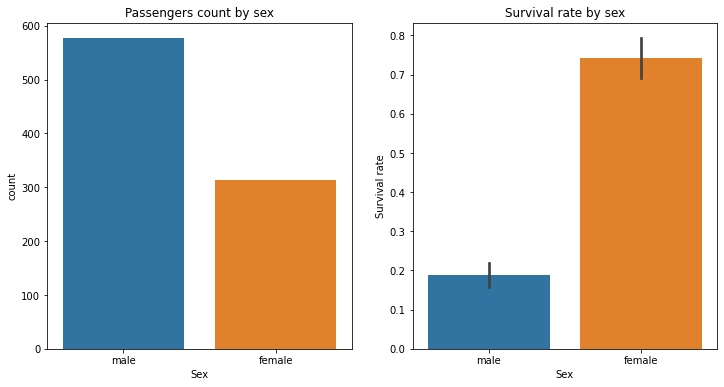

In [106]:
fig, axarr = plt.subplots(1, 2, figsize=(12,6))
a = sns.countplot(train['Sex'], ax=axarr[0]).set_title('Passengers count by sex')
axarr[1].set_title('Survival rate by sex')
b = sns.barplot(x='Sex', y='Survived', data=train, ax=axarr[1]).set_ylabel('Survival rate')

## 2.2. Pclass

In [107]:
# survival rate by class
train.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

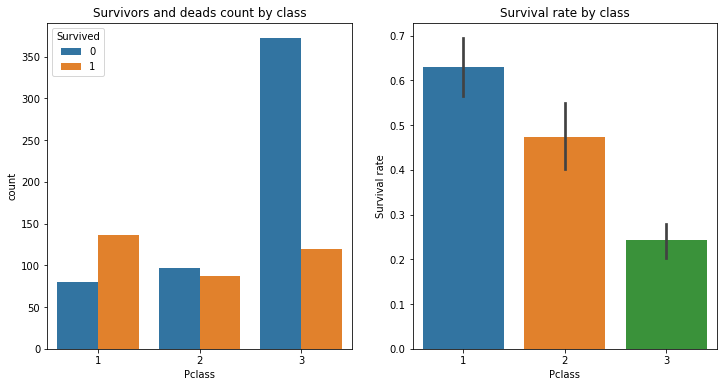

In [108]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(x='Pclass', hue='Survived', data=train, ax=axarr[0]).set_title('Survivors and deads count by class')
axarr[1].set_title('Survival rate by class')
b = sns.barplot(x='Pclass', y='Survived', data=train, ax=axarr[1]).set_ylabel('Survival rate')

In [109]:
# survival rate by class
train.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

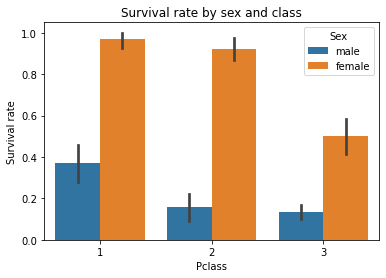

In [110]:
plt.title('Survival rate by sex and class')
g = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train).set_ylabel('Survival rate')

## 2.3 Sex

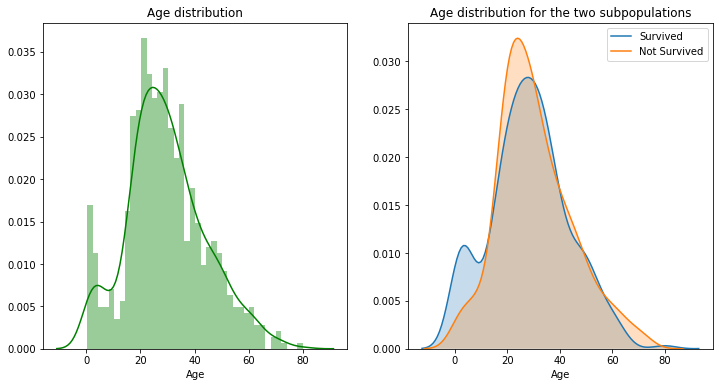

In [111]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
axarr[0].set_title('Age distribution')
f = sns.distplot(train['Age'], color='g', bins=40, ax=axarr[0])
axarr[1].set_title('Age distribution for the two subpopulations')
g = sns.kdeplot(train['Age'].loc[train['Survived'] == 1], 
                shade= True, ax=axarr[1], label='Survived').set_xlabel('Age')
g = sns.kdeplot(train['Age'].loc[train['Survived'] == 0], 
                shade=True, ax=axarr[1], label='Not Survived')

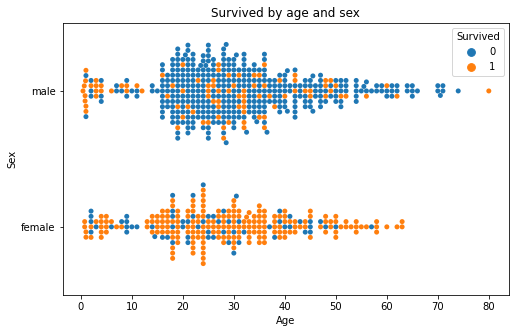

In [112]:
plt.figure(figsize=(8,5))
g = sns.swarmplot(y='Sex', x='Age', hue='Survived', data=train).set_title('Survived by age and sex')

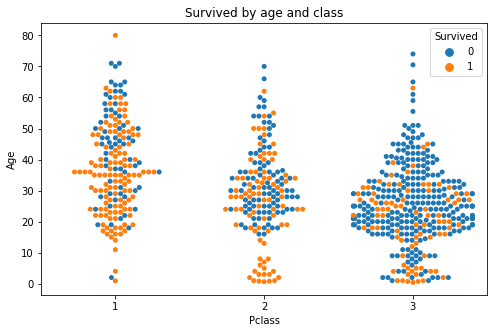

In [113]:
plt.figure(figsize=(8,5))
h = sns.swarmplot(x='Pclass', y='Age', hue='Survived', data=train).set_title('Survived by age and class')

## 2.4 Fare

In [114]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

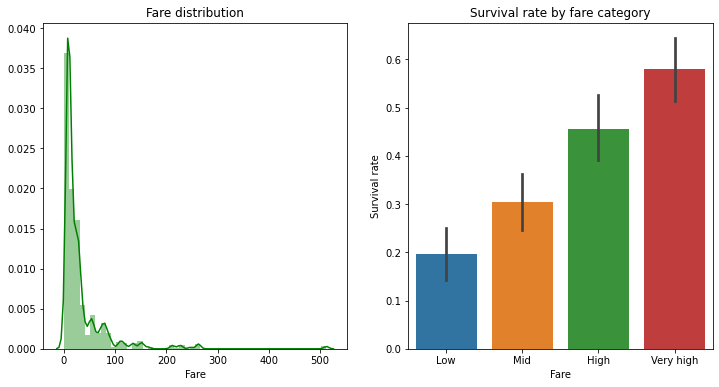

In [115]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
f = sns.distplot(train.Fare, color='g', ax=axarr[0]).set_title('Fare distribution')
fare_ranges = pd.qcut(train.Fare, 4, labels = ['Low', 'Mid', 'High', 'Very high'])
axarr[1].set_title('Survival rate by fare category')
g = sns.barplot(x=fare_ranges, y=train.Survived, ax=axarr[1]).set_ylabel('Survival rate')

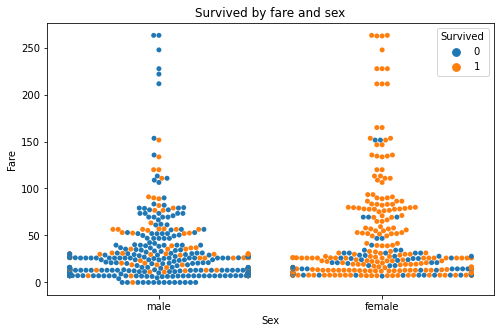

In [116]:
plt.figure(figsize=(8,5))
# I excluded the three outliers with fare > 500 from this plot
a = sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=train.loc[train.Fare<500]).set_title('Survived by fare and sex')

In [117]:
# passenger with free ticket or mistake?
train.loc[train.Fare==0]

PassengerId  Survived  Pclass                              Name   Sex  \
179          180         0       3               Leonard, Mr. Lionel  male   
263          264         0       1             Harrison, Mr. William  male   
271          272         1       3      Tornquist, Mr. William Henry  male   
277          278         0       2       Parkes, Mr. Francis "Frank"  male   
302          303         0       3   Johnson, Mr. William Cahoone Jr  male   
413          414         0       2    Cunningham, Mr. Alfred Fleming  male   
466          467         0       2             Campbell, Mr. William  male   
481          482         0       2  Frost, Mr. Anthony Wood "Archie"  male   
597          598         0       3               Johnson, Mr. Alfred  male   
633          634         0       1     Parr, Mr. William Henry Marsh  male   
674          675         0       2        Watson, Mr. Ennis Hastings  male   
732          733         0       2              Knight, Mr. Robert J  male   
806          807         0       1            Andrews, Mr. Thomas Jr  male   
815          816         0       1                  Fry, Mr. Richard  male   
822          823         0       1   Reuchlin, Jonkheer. John George  male   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
179  36.0      0      0    LINE   0.0   NaN        S  
263  40.0      0      0  112059   0.0   B94        S  
271  25.0      0      0    LINE   0.0   NaN        S  
277   NaN      0      0  239853   0.0   NaN        S  
302  19.0      0      0    LINE   0.0   NaN        S  
413   NaN      0      0  239853   0.0   NaN        S  
466   NaN      0      0  239853   0.0   NaN        S  
481   NaN      0      0  239854   0.0   NaN        S  
597  49.0      0      0    LINE   0.0   NaN        S  
633   NaN      0      0  112052   0.0   NaN        S  
674   NaN      0      0  239856   0.0   NaN        S  
732   NaN      0      0  239855   0.0   NaN        S  
806  39.0      0      0  112050   0.0   A36        S  
815   NaN      0      0  112058   0.0  B102        S  
822  38.0      0      0   19972   0.0   NaN        S

## 2.5 Embarked

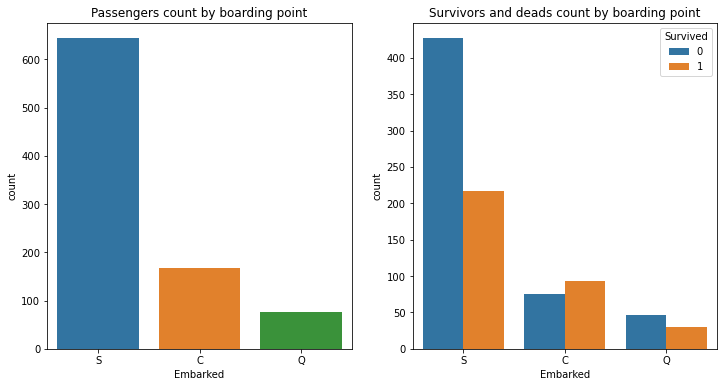

In [118]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
sns.countplot(train['Embarked'], ax=axarr[0]).set_title('Passengers count by boarding point')
p = sns.countplot(x = 'Embarked', hue = 'Survived', data = train, 
                  ax=axarr[1]).set_title('Survivors and deads count by boarding point')

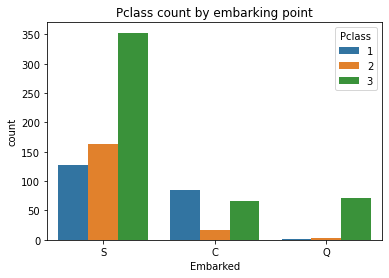

In [119]:
g = sns.countplot(data=train, x='Embarked', hue='Pclass').set_title('Pclass count by embarking point')

## 2.6 Name

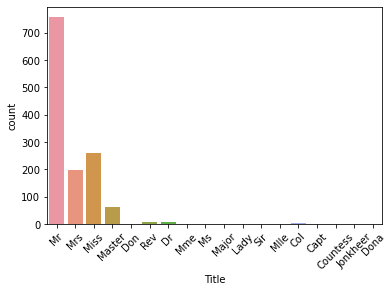

In [120]:
# Extract Title from Name, store in column and plot barplot
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

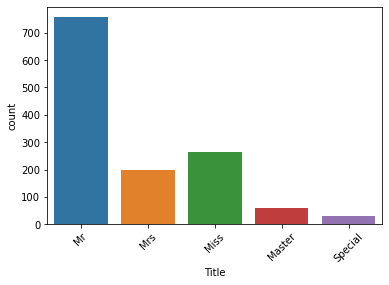

In [121]:
# Substitute titles and plot barplot
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

## 2.7 SibSp

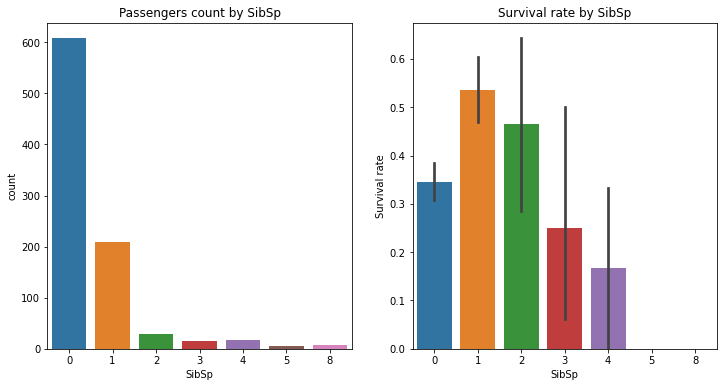

In [122]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(train['SibSp'], ax=axarr[0]).set_title('Passengers count by SibSp')
axarr[1].set_title('Survival rate by SibSp')
b = sns.barplot(x='SibSp', y='Survived', data=train, ax=axarr[1]).set_ylabel('Survival rate')

## 2.8 Parch

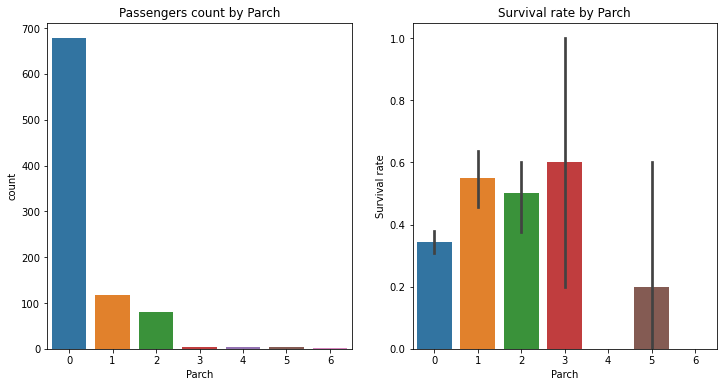

In [123]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(train['Parch'], ax=axarr[0]).set_title('Passengers count by Parch')
axarr[1].set_title('Survival rate by Parch')
b = sns.barplot(x='Parch', y='Survived', data=train, ax=axarr[1]).set_ylabel('Survival rate')

# 3. Data engineering

In [124]:
# Create column of number of Family members onboard
data['Fam_Size'] = data.Parch + data.SibSp + 1
data['Fam_type'] = pd.cut(data.Fam_Size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

In [125]:
# Extract the first two letters
data['Ticket_lett'] = data.Ticket.apply(lambda x: x[:2])
# Calculate ticket length
data['Ticket_len'] = data.Ticket.apply(lambda x: len(x))

In [126]:
# fill NaN
data['Age'] = data['Age'].interpolate(limit_direction='both', method='linear')
data['Fare'] = data['Fare'].interpolate(limit_direction='both', method='linear')
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].value_counts().index[0])

In [128]:
# Binning numerical columns
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False )

In [129]:
# remove unneeded columns
data = data.drop(['PassengerId', 'Name', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'Fam_Size', 'Age'], axis = 1)

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Pclass       1309 non-null   int64   
 1   Sex          1309 non-null   object  
 2   Fare         1309 non-null   float64 
 3   Embarked     1309 non-null   object  
 4   Title        1309 non-null   object  
 5   Fam_type     1309 non-null   category
 6   Ticket_lett  1309 non-null   object  
 7   Ticket_len   1309 non-null   int64   
 8   CatAge       1309 non-null   int64   
dtypes: category(1), float64(1), int64(3), object(4)
memory usage: 133.5+ KB


In [131]:
# Transform into binary variables
data_dun = pd.get_dummies(data, drop_first=True)
data_dun.shape

(1309, 73)

In [132]:
# extract Y values
y_train = train['Survived']

In [133]:
# create Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5)

In [134]:
# split to train and test
data_dun_train = data_dun[:891]
data_dun_test = data_dun[891:]

In [135]:
# random under-sampling
ros = RandomUnderSampler(random_state=0)
ros.fit(data_dun_train, y_train)
X_resampled, y_resampled = ros.fit_sample(data_dun_train, y_train)

# 4. Modeling

## 4.1 LogisticRegression. With under-sampling or no under-sampling

In [136]:
lr = LogisticRegression(max_iter = 10000, penalty="l2")

In [137]:
grid_values = {'C': [0.001,0.01,0.1,1,10,100,1000]} 
model_lr = GridSearchCV(lr, param_grid=grid_values)

In [138]:
# first experiment with under-sampling
model_lr.fit(X_resampled, y_resampled)
model_lr.best_params_

{'C': 1}

In [139]:
lr_1 = LogisticRegression(C = 1, max_iter = 10000, penalty="l2")

In [140]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(lr_1, skf, X_resampled, y_resampled)

ROC-AUC: 0.8705336994132692
PR-AUC: 0.8811257673294843
Precission: 0.8331906770986646
Recall: 0.804305200341006


In [141]:
# second experiment without under-sampling
model_lr.fit(data_dun_train, y_train)
model_lr.best_params_

{'C': 10}

In [142]:
lr_2 = LogisticRegression(C = 10, max_iter = 10000, penalty="l2")

In [143]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(lr, skf, data_dun_train, y_train)

ROC-AUC: 0.8760581192624999
PR-AUC: 0.8476950509520387
Precission: 0.794889705882353
Recall: 0.7248081841432226


**No undersampling is better**

## 4.2 RandomForestClassifier 

In [144]:
random_forest = RandomForestClassifier()

In [145]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(random_forest, hyperF, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(data_dun_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 23.9min finished


In [146]:
gridF.best_params_

{'max_depth': 25,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'n_estimators': 500}

In [147]:
random_forest = RandomForestClassifier(max_depth = 25, min_samples_leaf = 1, min_samples_split = 15, n_estimators = 500)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(random_forest, skf, data_dun_train, y_train)

ROC-AUC: 0.8788635794819071
PR-AUC: 0.8497029978542736
Precission: 0.837918980660916
Recall: 0.7190110826939471


## 4.3 Stochastic Gradient Descent (SGD)

In [148]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]
}

model = SGDClassifier(max_iter=5, tol=None)
clf = GridSearchCV(model, param_grid=params)

In [149]:
bestF_sgd = clf.fit(data_dun_train, y_train)

In [150]:
bestF_sgd.best_score_

0.7811625133387735

In [151]:
bestF_sgd.best_estimator_

SGDClassifier(alpha=0.001, loss='log', max_iter=5, penalty='l1', tol=None)

In [199]:
sgd_best = SGDClassifier(alpha=0.001, loss='log', max_iter=5, penalty='l1', tol=None)

In [200]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc_2(sgd_best, skf, data_dun_train, y_train)

ROC-AUC: 0.676199870309657
PR-AUC: 0.5366676809021861
Precission: 0.639840737687009
Recall: 0.6906649616368286


## 4.4 K Nearest Neighbor

In [154]:
X_train, X_test, y_train_2, y_test = train_test_split(data_dun_train, y_train, test_size=0.25)

In [155]:
knn = KNeighborsClassifier() 

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]

for k in k_choices:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train_2)
    y_pred_prob = knn.predict_proba(X_test)[:,1]
    #print(k)
    print('k = ', k, ' ROC-AUC:', roc_auc_score(y_test, y_pred_prob))

k =  1  ROC-AUC: 0.725234441602728
k =  2  ROC-AUC: 0.732693947144075
k =  3  ROC-AUC: 0.7561381074168798
k =  5  ROC-AUC: 0.7553708439897698
k =  8  ROC-AUC: 0.7530690537084399
k =  10  ROC-AUC: 0.7589087809036656
k =  15  ROC-AUC: 0.7733589087809036
k =  20  ROC-AUC: 0.7480392156862745
k =  25  ROC-AUC: 0.7404944586530264
k =  50  ROC-AUC: 0.7316709292412618


In [201]:
knn_best = KNeighborsClassifier(n_neighbors=15) 
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(knn_best, skf, data_dun_train, y_train)

ROC-AUC: 0.7831044928033947
PR-AUC: 0.6498050668807855
Precission: 0.6946350548988859
Recall: 0.5589087809036658


## 4.5 Gaussian Naive Bayes

In [157]:
gaussian = GaussianNB() 
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(gaussian, skf, data_dun_train, y_train)

ROC-AUC: 0.7189696443540973
PR-AUC: 0.5661087054715923
Precission: 0.42964772823069436
Recall: 0.9297101449275361


Naive Bayes doesn't have any hyperparameters to tune

## 4.6 Perceptron

In [158]:
params = {
    "max_iter" : [1, 5, 10, 50, 100, 1000],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]
}

model = Perceptron(tol=None)
per = GridSearchCV(model, param_grid=params)

In [159]:
per_best = per.fit(data_dun_train, y_train)

In [160]:
per_best.best_score_

0.7866863348189066

In [161]:
per_best.best_params_

{'alpha': 0.001, 'max_iter': 1000, 'penalty': 'l1'}

In [202]:
perceptron = Perceptron(alpha=0.001, max_iter=1000, penalty='l1', tol=None)
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc_2(perceptron, skf, data_dun_train, y_train)

ROC-AUC: 0.7901963415093709
PR-AUC: 0.6482590640277163
Precission: 0.7247223828802776
Recall: 0.8042625745950556


## 4.7 Decision Tree

In [163]:
decision_tree = DecisionTreeClassifier() 

In [164]:
# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(criterion=['gini', 'entropy'],
                  max_depth = [1,2,4,6,8,12],
                  min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35, 100],
                  min_samples_leaf = [1, 2, 5, 10])

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf_dt = GridSearchCV(decision_tree, parameters)

# Fit the grid search
clf_dt.fit(data_dun_train, y_train)

# View The Best Parameters
print('Best Criterion:', clf_dt.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_dt.best_estimator_.get_params()['max_depth'])
print('Best min samples split:', clf_dt.best_estimator_.get_params()['min_samples_split'])
print('Best max depth:', clf_dt.best_estimator_.get_params()['min_samples_leaf'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf_dt, data_dun_train, y_train, cv=5, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: gini
Best max_depth: 4
Best min samples split: 30
Best max depth: 1

[0.81564246 0.76966292 0.85393258 0.8258427  0.85955056]

0.8249262444291006

0.032190913486112166


In [165]:
clf_dt.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 30}

In [203]:
decision_tree_best = DecisionTreeClassifier(criterion='gini',max_depth=4,min_samples_leaf=1,min_samples_split=30) 
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(decision_tree_best, skf, data_dun_train, y_train)

ROC-AUC: 0.8655910793805864
PR-AUC: 0.8044740414402923
Precission: 0.8018915307585507
Recall: 0.7658141517476555


## 4.8 XGBoost

In [167]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [.4, .45, .5, .55, .6],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(data_dun_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters found:  {'subsample': 0.7, 'reg_lambda': 5.0, 'n_estimators': 17, 'min_child_weight': 0.5, 'max_depth': 7, 'learning_rate': 0.6, 'gamma': 1.0, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0}
Best accuracy found:  0.8383832262756029


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.5s finished


In [168]:
best_score = xgb_random.best_score_
best_params = xgb_random.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.8383832262756029
Best params: 
colsample_bylevel: 1.0
colsample_bytree: 0.7
gamma: 1.0
learning_rate: 0.6
max_depth: 7
min_child_weight: 0.5
n_estimators: 17
reg_lambda: 5.0
subsample: 0.7


In [204]:
xgb_best = XGBClassifier(colsample_bylevel=1.0, colsample_bytree=0.7,gamma=1.0,learning_rate=0.6,
                         max_depth=7,min_child_weight=0.5,n_estimators=17,reg_lambda=5.0,
                         subsample=0.7)

In [205]:
roc_auc, pr_auc, precision, recall, models = get_cv_roc_pr_rc(xgb_best, skf, data_dun_train, y_train)

ROC-AUC: 0.880168965399555
PR-AUC: 0.8575181069156368
Precission: 0.8160237050960735
Recall: 0.7193520886615515


# 5. Solution

## 5.1 With Random Forest 

In [206]:
random_forest.fit(data_dun_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_split=15, n_estimators=500)

In [207]:
y_pred = pd.DataFrame(random_forest.predict(data_dun_test), columns=['Survived'])

In [208]:
sub = pd.concat([test.PassengerId, y_pred], axis=1)

In [209]:
sub = sub.set_index(['PassengerId'])

In [210]:
sub.to_csv('titanic_RF_1.csv')

## 5.2 With XGBClassifier

In [211]:
y_pred = pd.DataFrame(xgb_best.predict(data_dun_test), columns=['Survived'])

In [212]:
sub = pd.concat([test.PassengerId, y_pred], axis=1)

In [213]:
sub = sub.set_index(['PassengerId'])

In [214]:
sub.to_csv('titanic_XGB_1.csv')

## 5.3 With Keras

In [180]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed
import tensorflow
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [181]:
ss = StandardScaler()
data_train_scaler = ss.fit_transform(data_dun_train)
data_test_scaler = ss.fit_transform(data_dun_test)

In [182]:
lyrs = [8]

In [183]:
print(len(lyrs))

1


In [184]:
for i in range(1,len(lyrs)):
    print(i)

In [185]:
def create_model(lyrs=[8], act='linear', opt='Adam', dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    #tensorflow.set_random_seed(42)
    tensorflow.random.set_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=data_train_scaler.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [186]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 592       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
None


In [187]:
# train model on full train set, with 80/20 CV split
training = model.fit(data_train_scaler, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
#training.history['val_accuracy']
val_acc = np.mean(training.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 81.99%


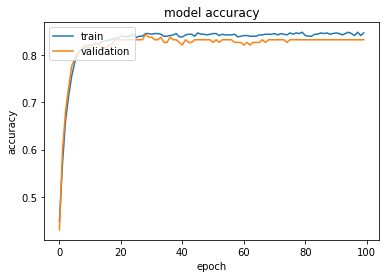

In [188]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [189]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# search the grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid,
                    cv=3,
                    verbose=2)  # include n_jobs=-1 if you are using CPU

grid_result = grid.fit(data_train_scaler, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... batch_size=16, epochs=50, total=   2.6s
[CV] batch_size=16, epochs=50 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ......................... batch_size=16, epochs=50, total=   2.8s
[CV] batch_size=16, epochs=50 ........................................
[CV] ......................... batch_size=16, epochs=50, total=   2.6s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   4.5s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   4.3s
[CV] batch_size=16, epochs=100 .......................................
[CV] ........................ batch_size=16, epochs=100, total=   4.3s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   1.6s
[CV] batch_size=32, epochs=50 ........................................
[CV] ......................... batch_size=32, epochs=50, total=   1.6s
[CV] batch_size=32, epochs=50 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   43.8s finished


In [190]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.794613 using {'batch_size': 16, 'epochs': 50}
0.794613 (0.002749) with: {'batch_size': 16, 'epochs': 50}
0.791246 (0.004762) with: {'batch_size': 16, 'epochs': 100}
0.790123 (0.004199) with: {'batch_size': 32, 'epochs': 50}
0.794613 (0.005498) with: {'batch_size': 32, 'epochs': 100}
0.787879 (0.005498) with: {'batch_size': 64, 'epochs': 50}
0.789001 (0.003174) with: {'batch_size': 64, 'epochs': 100}


In [191]:
# create model
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']
param_grid = dict(opt=optimizer)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(data_train_scaler, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................................... opt=SGD, total=   1.6s
[CV] opt=SGD .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .......................................... opt=SGD, total=   1.6s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   1.7s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   1.6s
[CV] opt=SGD .........................................................
[CV] .......................................... opt=SGD, total=   1.7s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   1.9s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   1.9s
[CV] opt=RMSprop .....................................................
[CV] ...................................... opt=RMSprop, total=   1.8s
[CV] opt=RMSprop .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   56.5s finished


In [192]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.819308 using {'opt': 'SGD'}
0.819308 (0.025932) with: {'opt': 'SGD'}
0.811437 (0.018428) with: {'opt': 'RMSprop'}
0.662181 (0.016731) with: {'opt': 'Adagrad'}
0.398374 (0.071245) with: {'opt': 'Adadelta'}
0.805831 (0.020939) with: {'opt': 'Adam'}
0.804714 (0.020832) with: {'opt': 'Nadam'}


In [193]:
# set random seed for reproducibility
seed(42)
#tensorflow.set_random_seed(42)
tensorflow.random.set_seed(42)

# create model
model = KerasClassifier(build_fn=create_model, 
                        epochs=50, batch_size=32, verbose=0)

# define the grid search parameters
layers = [[8],[10],[10,5],[12,6],[12,8,4]]
param_grid = dict(lyrs=layers)

# search the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=2)
grid_result = grid.fit(data_train_scaler, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] lyrs=[8] ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................................... lyrs=[8], total=   1.9s
[CV] lyrs=[8] ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ......................................... lyrs=[8], total=   1.9s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=   1.9s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=   2.3s
[CV] lyrs=[8] ........................................................
[CV] ......................................... lyrs=[8], total=   1.9s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   1.9s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   2.0s
[CV] lyrs=[10] .......................................................
[CV] ........................................ lyrs=[10], total=   2.0s
[CV] lyrs=[10] .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   50.9s finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbb0ad92410>, as the constructor either does not set or modifies parameter lyrs

In [194]:
model = Sequential()

In [195]:
len(data_train_scaler[1])

73

In [196]:
model.add(Dense(50, activation = 'relu', input_dim = 73))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [197]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [198]:
model.fit(data_train_scaler, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
90/90 [==============================] - 0s 2ms/step - loss: 0.6118 - accuracy: 0.6869
Epoch 2/100
90/90 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.8126
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 0.4020 - accuracy: 0.8395
Epoch 4/100
90/90 [==============================] - 0s 2ms/step - loss: 0.3780 - accuracy: 0.8563
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 0.3670 - accuracy: 0.8563
Epoch 6/100
90/90 [==============================] - 0s 1ms/step - loss: 0.3532 - accuracy: 0.8631
Epoch 7/100
90/90 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.8676
Epoch 8/100
90/90 [==============================] - 0s 2ms/step - loss: 0.3398 - accuracy: 0.8653
Epoch 9/100
90/90 [==============================] - 0s 2ms/step - loss: 0.3313 - accuracy: 0.8664
Epoch 10/100
90/90 [==============================] - 0s 2ms/step - loss: 0.3287 - accuracy: 0.8721
Epoch 11/

In [215]:
y_pred = pd.DataFrame(model.predict(data_test_scaler), columns=['Survived'])

In [216]:
sub = pd.concat([test.PassengerId, y_pred], axis=1)

In [217]:
sub['Survived'].values[sub['Survived'].values > 0.5] = 1
sub['Survived'].values[sub['Survived'].values <= 0.5] = 0
sub['Survived'] = sub['Survived'].astype(int)

In [218]:
sub = sub.set_index(['PassengerId'])

In [219]:
sub.to_csv('titanic_keras_1.csv')

### **XGB showed the best result - 0.78708. Keras - 0.78468 and random forest - 0.76555**